# <font color='#4C5FDA'>**Segmentación de imagenes vasculares de la retina** </font> <a name="tema1">

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaglle.

In [2]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"majinka10","key":"3d279682cba1b9e369b0c57794d7135e"}'}

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [4]:
!mkdir ~/kaggle

mkdir: cannot create directory ‘/root/kaggle’: File exists


In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


##<font color='#ECA702'>**Procesamiento del dataset**</font>

1. Instalamos [segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch), una librería que nos permite usar arquitecturas de modelos para clasificación binaria y multiclase. Además de encoders preentrenados.

In [6]:
#@title **Paquetes necesarios**
!pip install segmentation-models-pytorch

In [7]:
#@title **Importamos librerías necesarias**

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision.datasets import ImageFolder


# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.transforms.v2 as transforms

# Manipulación de datos (imágenes)
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Data agumentation
import albumentations as A

# Para el manejo de archivos
from PIL import Image
from glob import glob
from tqdm import tqdm

# Métricas
import segmentation_models_pytorch as smp

###<font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Retina Blood Vessel](https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel)
 desde kaggle.

 The dataset comprises a total of X high-resolution retinal fundus images captured using state-of-the-art imaging equipment. Each image comes with corresponding pixel-level ground truth annotations indicating the exact location of blood vessels. These annotations facilitate the development and evaluation of advanced segmentation algorithms.

 Use Cases:
 - Algorithm Development: Use the dataset to train and test innovative segmentation algorithms, leveraging the precise annotations to achieve accurate and reliable results.
 - Disease Detection: Create models that can assist in the early detection of retinal pathologies, contributing to timely medical interventions.

In [ ]:
! kaggle datasets download -d abdallahwagih/retina-blood-vessel
! unzip retina-blood-vessel.zip

Annotations: For each image, corresponding pixel-wise annotations in a binary mask format are provided. Blood vessel pixels are marked as 1, while background pixels are labeled as 0.

In [9]:
train_img_paths = sorted(glob('/content/Data/train/image/*.png'))
train_mask_paths = sorted(glob('/content/Data/train/mask/*.png'))
train_df = pd.DataFrame({"images":train_img_paths,"masks":train_mask_paths})
train_df.head()

,images,masks
0,/content/Data/train/image/0.png,/content/Data/train/mask/0.png
1,/content/Data/train/image/1.png,/content/Data/train/mask/1.png
2,/content/Data/train/image/10.png,/content/Data/train/mask/10.png
3,/content/Data/train/image/11.png,/content/Data/train/mask/11.png
4,/content/Data/train/image/12.png,/content/Data/train/mask/12.png


In [10]:
test_img_paths = sorted(glob('/content/Data/test/image/*.png'))
test_mask_paths = sorted(glob('/content/Data/test/mask/*.png'))
test_df = pd.DataFrame({"images":test_img_paths,"masks":test_mask_paths})
test_df.head()

,images,masks
0,/content/Data/test/image/0.png,/content/Data/test/mask/0.png
1,/content/Data/test/image/1.png,/content/Data/test/mask/1.png
2,/content/Data/test/image/10.png,/content/Data/test/mask/10.png
3,/content/Data/test/image/11.png,/content/Data/test/mask/11.png
4,/content/Data/test/image/12.png,/content/Data/test/mask/12.png


###<font color='#52F17F'>**Visualización de datos**</font>

In [11]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

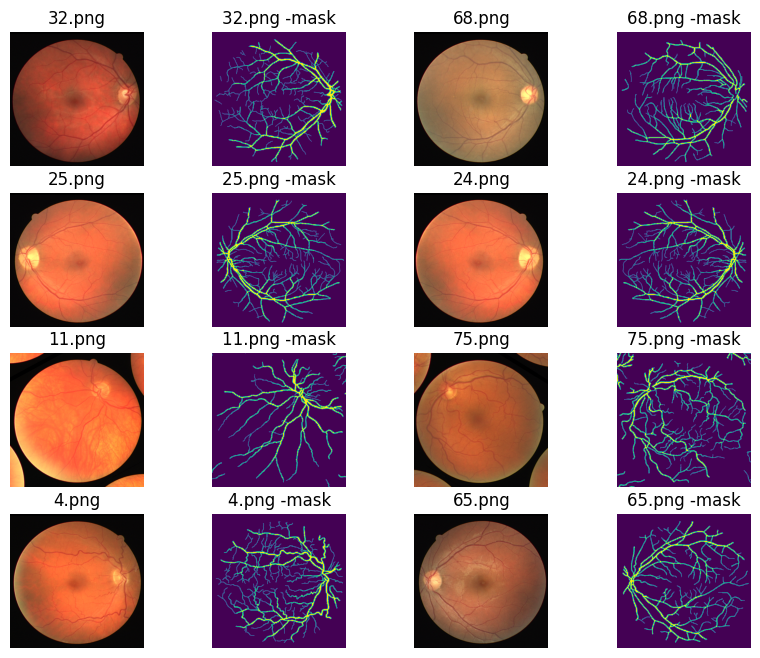

In [12]:
show_imgs = 8
idx = np.random.choice(len(train_df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(10, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path)
    else:
        full_path = train_df.loc[idx[new_i]]['masks']
        basename = os.path.basename(full_path) + ' -mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

###<font color='#52F17F'>**Data augmentation**</font>

In [13]:
### Elige trasnformaciones para hacer data augmentation
### Puedes encontrar informacion acerca de las transformaciones disponibles en https://albumentations.ai/docs/api_reference/augmentations/
train_transforms = A.Compose([
  A.Resize(512, 512, always_apply=True),
  A.RandomRotate90(p=0.7),
  A.MotionBlur(blur_limit=45, p=0.9),
  A.GaussNoise(p=0.2),
  A.OneOf(
      [
          A.RandomBrightnessContrast(p=0.6),
          A.HueSaturationValue(p=0.4),
      ],
      p=0.9,
  ),

  A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08, p=0.2)
])

test_transforms = A.Compose([
    A.Resize(512, 512, always_apply=True),
])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None, preprocessing=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Leer las rutas de las imágenes y las máscaras desde el DataFrame
        image_path = self.df.iloc[index]['images']
        mask_path = self.df.iloc[index]['masks']

        # Cargar las imágenes y las máscaras desde las rutas
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread((mask_path), cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)

        # Aplicar transformaciones si están definidas
        if self.transforms_:
            aug = self.transforms_(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        img = img / 255.0  # Normalizar la imagen

        # apply preprocessing
        if self.preprocessing:
          img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
          mask = torch.tensor(mask, dtype=torch.long)

        return {'image': img, 'mask': mask}

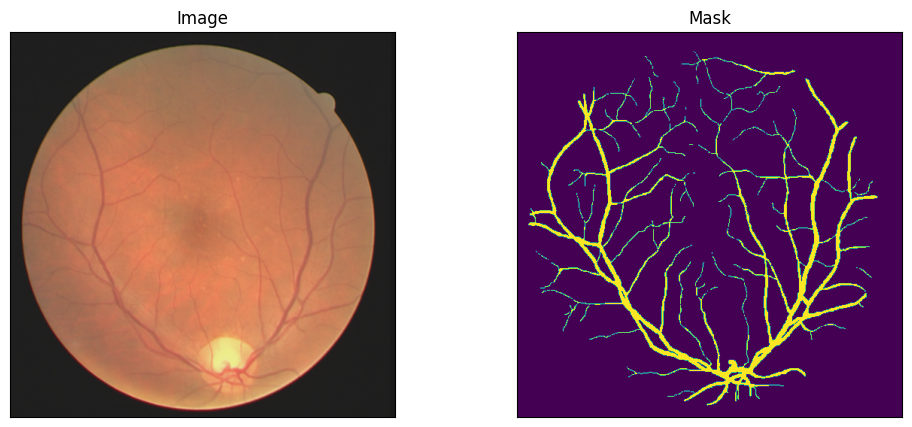

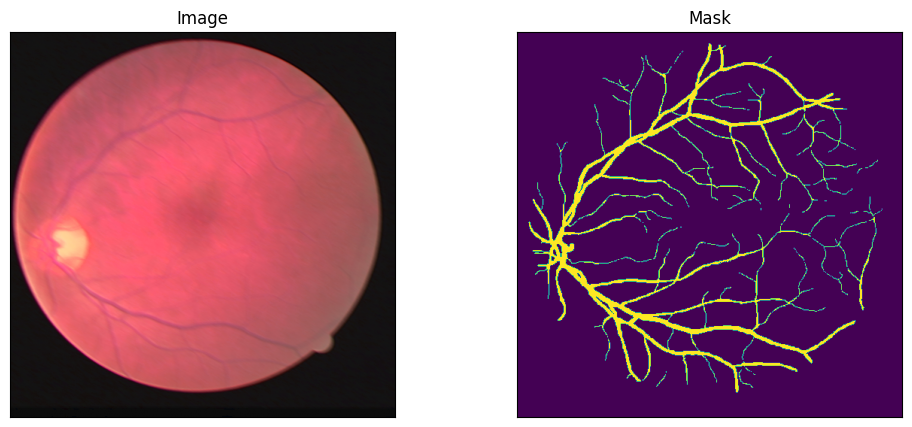

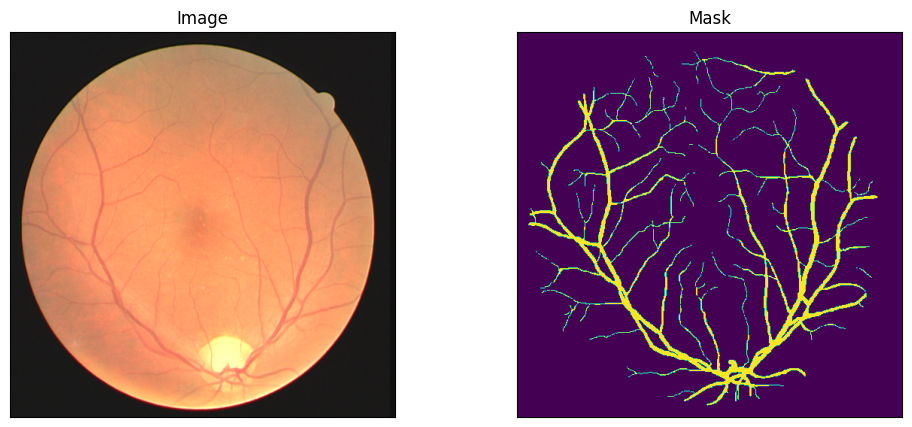

In [14]:
augmented_dataset = MyDataset(train_df, train_transforms)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1].values()
    visualize(image=image, mask=mask)

##<font color='#ECA702'>**Modelo CNN**</font>

**U-net architecture**

The network architecture is illustrated in Figure 1. It consists of a contracting
path (left side) and an expansive path (right side). The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels
in every convolution. At the final layer a 1x1 convolution is used to map each
64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

<div align="center"> <image src="https://imgs.search.brave.com/6lbIK-xzYuzh28AextLXfu6l0sxRrVbSexgE3eSLp_Q/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZWVrc2Zvcmdl/ZWtzLm9yZy93cC1j/b250ZW50L3VwbG9h/ZHMvMjAyMjA2MTQx/MjEyMzEvR3JvdXAx/NC5qcGc" width=600>  </div>


###<font color='#52F17F'>**Creando el modelo**</font>

In [15]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
     super().__init__()
     #Declara las capas necesarias para realizar la doble convolución descrita en
     # el diagrama de la UNet
     self.double_conv = nn.Sequential(
         nn.Conv2d(in_channels, out_channels, kernel_size=3),
         nn.ReLU(inplace=True),
         nn.Conv2d(out_channels, out_channels, kernel_size=3),
         nn.ReLU(inplace=True)
     )

  def forward(self, x):
    return self.double_conv(x)


class Downscaling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      nn.MaxPool2d(kernel_size=2, stride=2),
      DoubleConvBlock(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)


class Upscaling(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    ## Declara las capas necesarias para aumentar la escala de los mapas de caracteristicas
    ## Puedes emplear interpolación o convolución transpuesta para lograrlo
    self.up_conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, 2),
      DoubleConvBlock(in_channels, out_channels)
    )

  def forward(self, x1, x2):
      x1 = self.up_conv(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]

      x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x):
    return self.conv(x)

In [16]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=False):
    super().__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    ## Siguiendo la estructura de la Unet, crea el modelo con los bloques declarados arriba
    self.inc = DoubleConvBlock(n_channels, 64)
    self.down1 = Downscaling(64, 128)
    self.down2 = Downscaling(128, 256)
    self.down3 = Downscaling(256, 512)
    self.down4 = Downscaling(512, 1024)
    self.up_conv1 = Upscaling(1024, 512)
    self.up_conv2 = Upscaling(512, 256)
    self.up_conv3 = Upscaling(256, 128)
    self.up_conv4 = Upscaling(128, 64)
    self.out = OutConv(64, n_classes)

  def forward(self, x):
    ## Crea el forward de la UNet, no olvides las conexiones residuales
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x6 = self.up_conv1(x5, x4)
    x7 = self.up_conv2(x6, x3)
    x8 = self.up_conv3(x7, x2)
    x9 = self.up_conv4(x8, x1)
    logits = self.out(x9)
    return logits

###<font color='#52F17F'>**Entrenamiento del modelo**</font>

In [17]:
train_dataset = MyDataset(train_df,
                          transforms_= train_transforms,
                          preprocessing=True)
val_dataset = MyDataset(test_df,
                        transforms_ = test_transforms,
                        preprocessing= True) #Invoca la clase MyDataset declarada para el dataset de validacion

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
print(f'len train: {len(train_df)}')
print(f'len val: {len(test_df)}')

len train: 80
len val: 20


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_channels=3, n_classes=1)

model.to(device)
criterion = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
epochs = 15

for epoch in range(epochs+1):
  model.train()
  epoch_loss = 0
  epoch_iou_score = 0
  train_iters = 0

  for _, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')):

    images, true_mask = batch['image'].to(device), batch['mask'].to(device)
    optimizer.zero_grad()

    pred_masks = model(images)
    pred = pred_masks.squeeze(dim=1)

    loss = criterion(pred, true_mask)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    true_mask = true_mask.round().long()
    tp, fp, fn, tn = smp.metrics.get_stats(pred, true_mask, mode='binary', threshold=0.5)
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
    epoch_iou_score += iou_score
    train_iters += 1

  print(f"Epoch Loss: {epoch_loss/train_iters:.4f}, Dice: {loss:.4f}, IoU: {epoch_iou_score:.4f}")

Epoch 0/15:   0%|          | 0/5 [00:42<?, ?it/s]


RuntimeError: Given groups=1, weight of size [512, 1024, 3, 3], expected input[16, 512, 25, 25] to have 1024 channels, but got 512 channels instead

##<font color='#ECA702'>**Evaluación del modelo**</font>

In [ ]:
model.eval()
epoch_loss = None
train_iters = None
epoch_iou_score = None

with torch.no_grad():
    for _, batch in enumerate(tqdm(val_loader, desc=f'Epoch {epoch}/{epochs}')):
        images, true_masks = batch['image'].to(device), batch['mask'].to(device)

        pred = model(images)
        loss = criterion(pred, true_masks)

        epoch_loss += loss.item()
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        true_mask = true_mask.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, true_mask, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        train_iters += 1

print(f"Epoch Loss: {epoch_loss/train_iters:.4f}, Dice: {loss:.4f}, IoU: {epoch_iou_score/train_iters:.4f}")

###<font color='#52F17F'>**Inferencia del modelo**</font>



In [ ]:
#images, masks = next(iter(val_loader))
images, masks = batch['image'].to(device), batch['mask'].to(device)
with torch.no_grad():
  model_prediction = model(images)

model_prediction = torch.max(model_prediction,dim=1)[0]

rows, columns = 2, 6
num_images = 24
fig, axs = plt.subplots(rows, columns, figsize=(15, 6))
idx = 0
for row in range(rows):
    for col in range(0, 6, 3):
      if idx >= num_images:
          break

      img = images[idx].permute(1, 2, 0)
      mask = masks[idx].squeeze()
      predicted_masks = model_prediction[idx]


      axs[row, col].imshow(img.cpu())
      axs[row, col].set_title('Input image')
      axs[row, col].axis('off')

      axs[row, col+1].imshow(mask.cpu())
      axs[row, col+1].set_title('Target Mask')
      axs[row, col+1].axis('off')

      axs[row, col+2].imshow(predicted_masks.cpu())
      axs[row, col+2].set_title('Predicted Mask')
      axs[row, col+2].axis('off')

      idx += 1

plt.tight_layout()
plt.show()